# Week 5

In deze notebook ga je oefenen hoe je gebruik kan maken van reeds getrainde machine learning modellen om het trainen van modellen te versnellen en eenvoudiger goede resultaten te bekomen.

Reeds getrainde modellen of pretraind modellen kunnen gebruikt worden op de volgende manieren:
* Volledig / zonder wijziging
* Met transfer learning
* Fine-tuning

Er zijn verschillende bronnen van online modellen. Sommige zijn open source en kan je eenvoudig zelf inlezen en manipuleren.
Een grote selectie van pretrained modellen kan je vinden op [tensorflow hub](https://www.tensorflow.org/hub).
Daarnaast zijn er een aantal pretrained modellen aanwezig via tensorflow.keras.applications.
Een derde optie is om op google te zoeken naar een bestaand model (vaak staan er implementaties op github).
Ten slotte zijn er ook verscheidene bedrijven die api's aanbieden waarmee je hun modellen kan gebruiken (al dan niet tegen betaling).
Deze zijn echter moeilijk om aan te passen waardoor je in deze notebook vooral gaat werken met de standaardmodellen van tensorflow.

## Zelf geschreven convolutioneel neuraal netwerk

Download eerst de dataset [Dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats) van Kaggle en unzip de test1.zip en train.zip files. Let op dat je eerst naar de link moet gaan en de regels van de competitie aanvaarden voor het automatisch downloaden werkt.

Schrijf daarna de nodige code voor een convolutioneel neuraal netwerk op te bouwen en te trainen. Welke accuraatheid behaal je voor dit classificatieprobleem?

In [1]:
# imports
import opendatasets as od
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomZoom, Resizing, Rescaling, Conv2D, MaxPooling2D, Flatten, Resizing, Dense
from tensorflow.keras import Sequential

In [3]:
# download data
od.download("https://www.kaggle.com/c/dogs-vs-cats/")


with ZipFile("./dogs-vs-cats/train.zip") as zf:
    zf.extractall("train")
    pass

with ZipFile("./dogs-vs-cats/test1.zip") as zf:
    zf.extractall("test")
    pass

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading dogs-vs-cats.zip to .\dogs-vs-cats


100%|██████████| 812M/812M [00:22<00:00, 37.6MB/s] 



Extracting archive .\dogs-vs-cats/dogs-vs-cats.zip to .\dogs-vs-cats


In [4]:
# lezen van de data
ds = tf.data.Dataset.list_files('.\\train\\train\\*', seed=123)   # dit is geshuffeled

# splits train en val
image_count = len(ds)
val_size = int(image_count * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

image_data = []
image_labels = []

for f in train_ds.take(5):
  print(f.numpy())

# get label from path
def get_label(file_path):  
  
  #regex match om te kijken of er cat in de naam staat
  # als je in deze functies werkt, wil je werken met tensorflow functies. Anders krijg je errors
  if tf.strings.regex_full_match(file_path, '.*[Cc][Aa][Tt].*'):    # ergens in het pad moet er cat staan (case insensitive)
    return 0  # cat is 0
  else:
    return 1  # hond is label 1

# lees img from file
def decode_img(img):

  img = tf.io.read_file(img) 
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [224, 224])

# hoe ga je van path naar tensors
def process_path(file_path):
  return decode_img(file_path), get_label(file_path)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

b'.\\train\\train\\dog.7203.jpg'
b'.\\train\\train\\dog.3349.jpg'
b'.\\train\\train\\cat.8152.jpg'
b'.\\train\\train\\dog.2534.jpg'
b'.\\train\\train\\dog.4487.jpg'


In [5]:
# bouwen van het model
model = Sequential([
    # preprocessing gedeelte
    Resizing(100, 100),
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomBrightness(0.001),

    # convolutioneel gedeelte
    Conv2D(5, 3, 1, 'same'),# 5 kernels, kernel_size =3 , stride 1, met padding -> dimensies blijven gelijk
    MaxPooling2D(),
    Conv2D(15, 3, 1, 'same'),
    MaxPooling2D(),
    Conv2D(30, 3, 1, 'same'),
    MaxPooling2D(),

    # fully connected gedeelte
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])


# binair classificatie probleem met 1 neuron -> binary cross entropy als loss functie
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [6]:
# trainen van het model
history = model.fit(train_ds, epochs=1, validation_data=val_ds)

625/625 [==============================] - 126s 192ms/step - loss: 0.6931 - acc: 0.5008 - val_loss: 0.6851 - val_acc: 0.5516


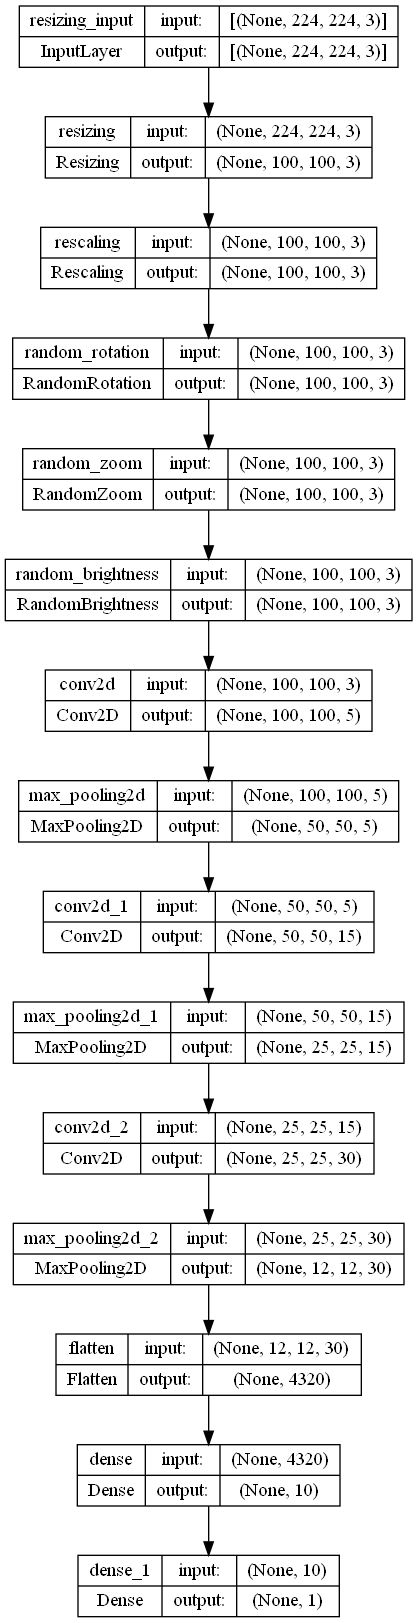

In [10]:
# plot model structuur
tf.keras.utils.plot_model(model, to_file="selfmademodel.png", show_shapes=True)

In [11]:
# plotten van een batch
def plot_images_with_labels(ds, batch_number=0, batch_size=32, predictions=None, list_labels=None):
    # Get the batch data
    img_batch, label_batch = next(iter(ds.skip(batch_number).take(1)))

    for i in range(batch_size):
        img = img_batch[i]
        label = label_batch[i]

        # Convert TensorFlow tensors to NumPy arrays
        img = img.numpy() / 255.
        label = label.numpy()
        
        # Create a figure and axis for plotting
        fig, ax = plt.subplots(1, figsize=(2, 2))
        
        # Plot the image
        ax.imshow(img)

        if predictions.shape[1] > 1:
            prediction = np.argmax(predictions[i+ batch_number*batch_size])
        else:
            prediction = int(np.round(predictions[i+ batch_number*batch_size, 0]))
        print(prediction)
        if list_labels is not None:
            prediction = list_labels[prediction]
        ax.set_title("True label: " + str(label) + " Predicted label: " + str(prediction))
                
        plt.show()

157/157 [==============================] - 5s 34ms/step
1


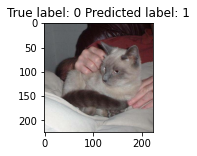

1


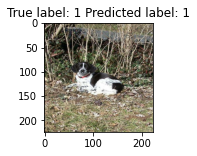

1


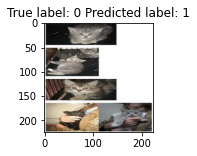

0


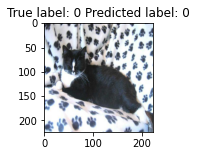

0


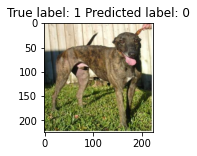

1


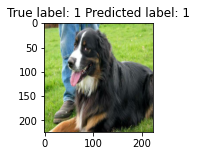

0


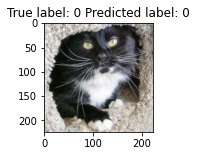

0


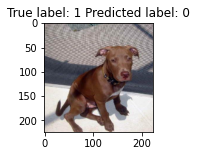

1


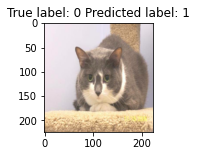

1


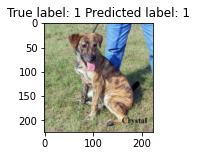

1


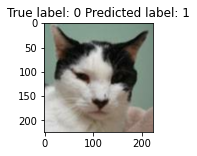

0


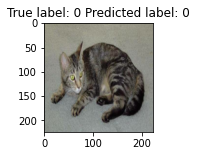

1


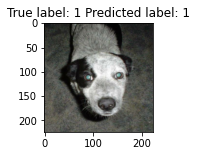

1


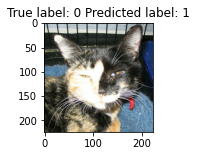

1


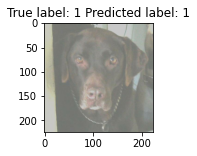

1


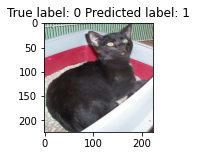

1


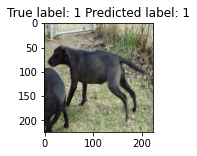

0


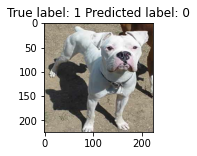

1


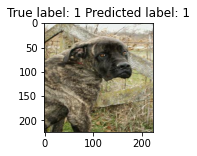

1


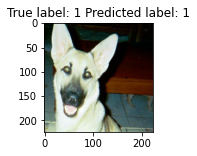

0


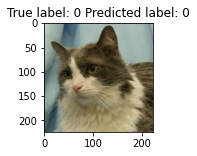

1


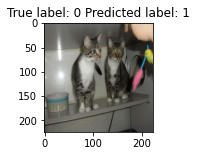

0


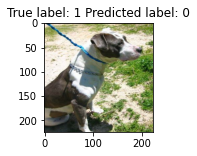

1


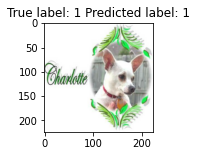

1


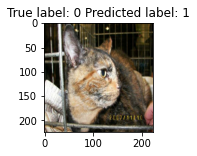

0


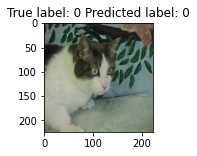

0


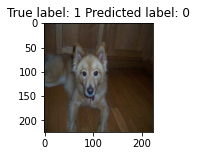

1


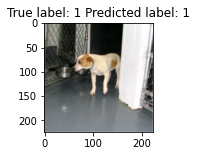

1


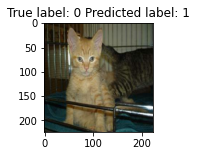

1


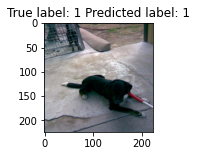

0


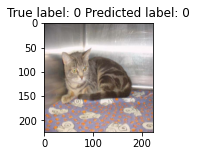

1


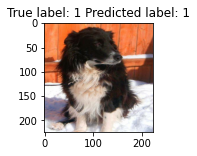

In [12]:
# plot predictions
predictions = model.predict(val_ds)
plot_images_with_labels(val_ds, batch_number=10, predictions=predictions)

## Pretrained netwerk

In sommige gevallen kan je een online een reeds bestaand model vinden dat rechtstreeks kan toegepast worden op je probleem. 
Dit is bijvoorbeeld gedaan bij de demo uit de eerste les voor object detection.

In de voorbeeldcode hieronder gaan we gebruik maken van een gekend netwerk in het domein van computervisie namelijk resnet.
Deze code laad het model volledig en we voorspellen de outputs zoals het netwerk getrained is.

In [13]:
# Downloading a list of labels corresponding to each class index
labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []
with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]
print(classes)

base_model = tf.keras.applications.ResNet152(weights='imagenet')

base_model.summary()

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', '

In [14]:
predictions = base_model.predict(val_ds.take(2))

2/2 [==============================] - 14s 6s/step


In [15]:
tf.keras.applications.resnet.decode_predictions(predictions)

[[('n02098286', 'West_Highland_white_terrier', 0.16678287),
  ('n02892767', 'brassiere', 0.053866312),
  ('n01770393', 'scorpion', 0.049372297),
  ('n03887697', 'paper_towel', 0.03905741),
  ('n15075141', 'toilet_tissue', 0.026058892)],
 [('n02110627', 'affenpinscher', 0.16432993),
  ('n02096177', 'cairn', 0.12544616),
  ('n02113624', 'toy_poodle', 0.07336327),
  ('n02104365', 'schipperke', 0.057385996),
  ('n02097298', 'Scotch_terrier', 0.051386025)],
 [('n02099267', 'flat-coated_retriever', 0.3799969),
  ('n02111277', 'Newfoundland', 0.31073833),
  ('n02099712', 'Labrador_retriever', 0.2918827),
  ('n02099429', 'curly-coated_retriever', 0.009358211),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.0021214208)],
 [('n03482405', 'hamper', 0.92758),
  ('n04204238', 'shopping_basket', 0.022997795),
  ('n02909870', 'bucket', 0.018447254),
  ('n02804414', 'bassinet', 0.010417025),
  ('n02123045', 'tabby', 0.0034911667)],
 [('n02328150', 'Angora', 0.20680724),
  ('n02120079', 'Arctic_fox', 0.

203


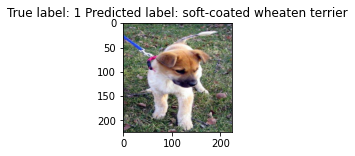

252


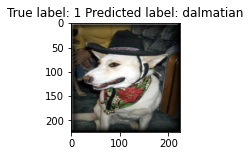

205


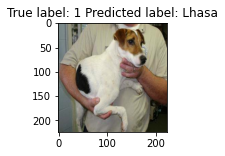

588


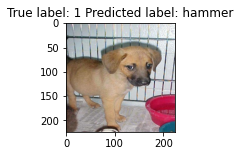

332


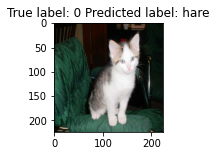

281


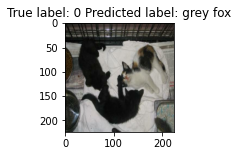

282


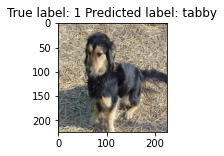

282


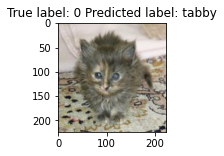

279


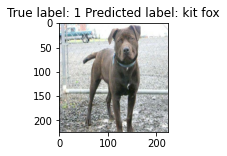

157


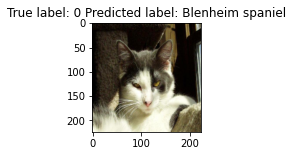

904


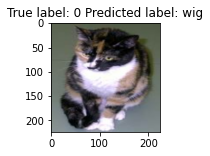

197


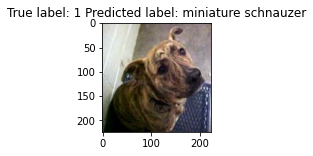

285


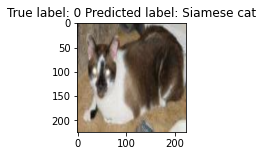

285


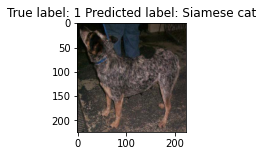

285


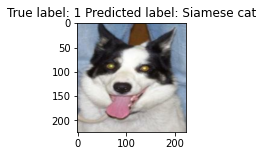

162


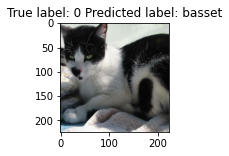

285


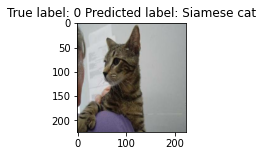

180


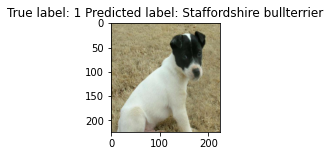

330


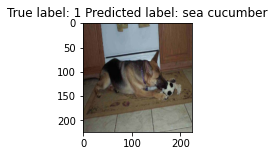

169


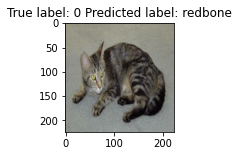

250


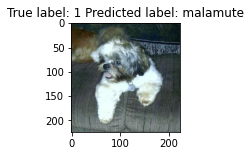

283


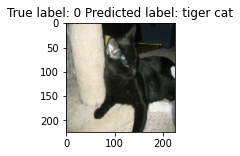

194


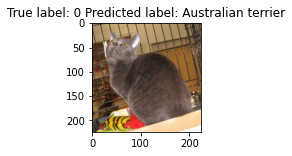

361


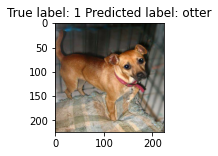

361


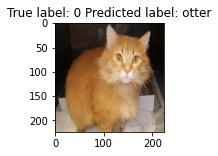

921


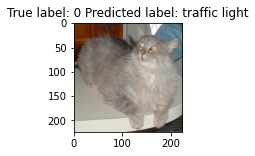

282


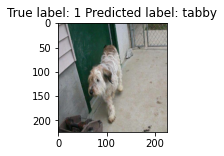

281


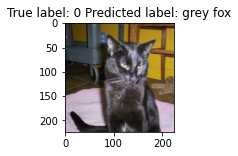

691


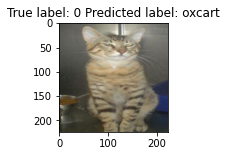

285


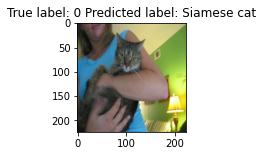

285


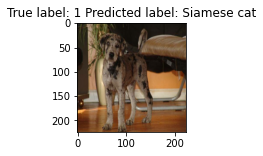

284


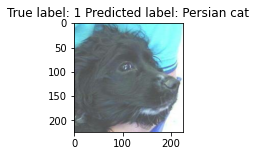

In [16]:
plot_images_with_labels(val_ds.take(2), batch_number=0, predictions=predictions, list_labels=classes)

## Transfer learning

Hoewel het gebruiken van pretrained netwerken heel handig is, is het maar zelden dat een bestaand netwerk exact kan gebruikt worden voor jouw probleem.
Gelukkig zijn er wel mogelijkheden om nog de geleerde features van een getrained model te behouden terwijl je het dan specialiseert voor jouw toepassing.
Dit reduceert de hoeveelheid data die je nog nodig hebt om jouw probleem goed op te lossen. 

Maak nu een nieuw convolutioneel netwerk aan dat gebruik maakt van het resnet neuraal netwerk.
Meer informatie over dit netwerk vind je [hier](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet152)
Gebruik transfer learning om dit model aan te passen door het fully-connected gedeelte te vervangen door:
* 1 laag met 100 neuronen
* 1 laag met voldoende neuronen voor de output

Compile het netwerk met de nodige parameters en bekijk eens de summary.
Hoeveel parameters zijn er nog maar trainable.
Dit geeft een groot voordeel op vlak van trainingstijd (ook omdat het vanishing gradient problem minder van toepassing is op de laatste lagen).

In [17]:
# load pretrained network and configure for transfer learning
base_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False)
base_model.trainable=False # de gewichten vast zetten

predictions = base_model.predict(val_ds.take(2))

predictions.shape

2/2 [==============================] - 14s 6s/step


(64, 7, 7, 2048)

In [20]:
# replace the fully-connected layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 58,471,297
Trainable params: 100,353
Non-trainable params: 58,370,944
_________________________________________________________________


In [21]:
# train the model
model.fit(train_ds.take(20), epochs=1, validation_data=val_ds.take(2))

20/20 [==============================] - 199s 10s/step - loss: 0.7357 - acc: 0.9094 - val_loss: 1.0889 - val_acc: 0.9219


2/2 [==============================] - 27s 12s/step
1


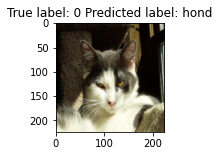

1


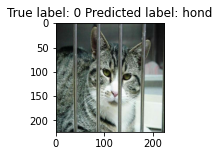

0


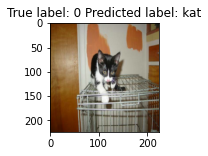

1


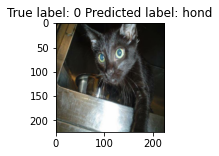

0


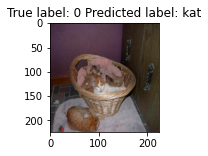

0


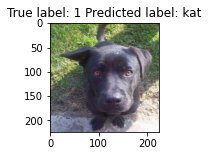

0


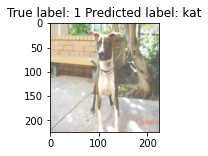

0


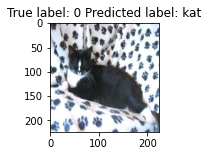

1


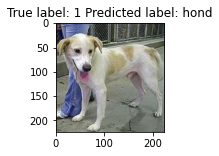

1


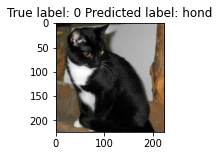

0


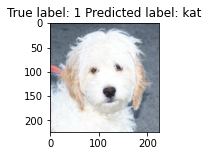

1


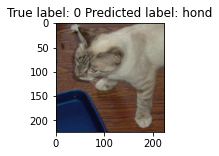

1


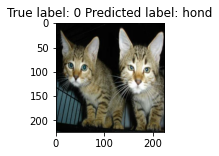

0


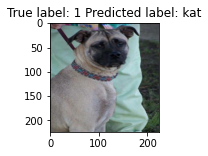

0


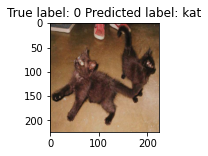

1


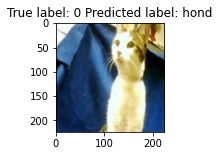

0


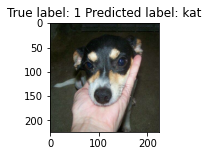

0


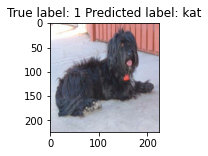

0


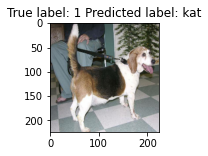

1


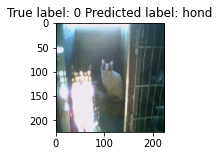

1


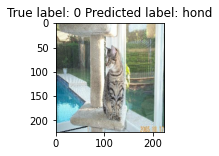

1


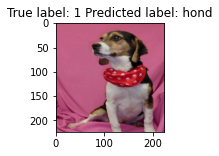

0


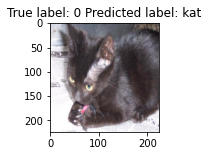

0


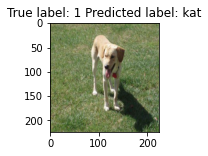

0


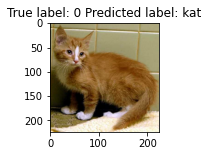

0


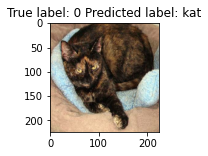

0


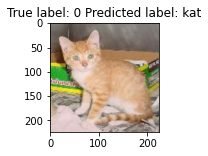

0


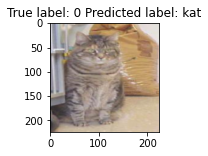

1


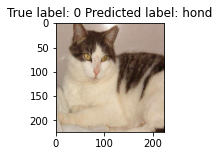

1


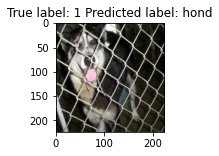

1


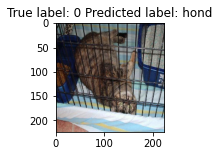

1


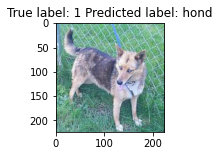

In [22]:
# plot the outputs
predictions = model.predict(val_ds.take(2))

plot_images_with_labels(val_ds.take(2), batch_number=0, predictions=predictions, list_labels=["kat", "hond"])

### Early stopping to prevent overfitting

Door gebruik te maken van transfer learning heb je reeds heel wat training achter de rug.
Hierdoor kan het zijn dat je je trainingsruns vroegtijdig wil afbreken indien je een bepaalde accuraatheid behaald hebt. 
Hiervoor kan je gebruik maken van een callback. Dit is een functie die na elke epoch opgeroepen wordt.
In deze functie kan je logs bijhouden, backups opslaan, de training onderbreken, ...

In de code hieronder wordt het leerproces onderbroken wanneer de validation loss niet meer veranderd.
Er zijn echter heel wat callbacks waarop je kan reageren om bijvoorbeeld data te fetchen, logs weg te schrijven, de vooruitgang te bestuderen.
Een overzicht van deze callbacks kan je [hier](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) vinden.

In [ ]:
# train with early stopping
history = model.fit(train_ds.take(2), epochs=1, callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)])

## Fine tuning

Bij transfer learning wordt een deel van de gewichten niet meer aangepast, namelijk deze van het convolutionele gedeelte van het CNN.
In sommige gevallen wil je echter niet alleen het laatste gedeelte aanpassen maar het hele neuraal netwerk fine-tunen met nieuwe data.
Dit kan bijvoorbeeld zijn als je continue nieuwe data binnenkrijgt die kan gebruikt worden om het CNN verder te trainen om de prestaties te verbeteren.

Let op dat een CNN bestaat uit een groot aantal convolutionele lagen.
De eerste van deze lagen extraheren heel eenvoudige en generieke features en dieper liggende lagen zoeken naar features die meer specifiek zijn aan de dataset waarop het model getrained wordt.
Het kan nodig zijn om deze dieper liggende lagen ook mee te trainen om het model beter te laten werken voor jouw probleem. 

Aangezien hier lagen niet vervangen worden maar verder getrained spreken we niet van transfer learning maar fine tuning. Meer informatie hierover en de bron van de voorbeeldcode hieronder kan je [hier](https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning) vinden.

**Opmerking:** Indien je het volledig netwerk fine-tuned komt dit overeen met hoe je recovered van failures. Stel dat er een crash is na epoch x. Dan kan je terug beginnen vanaf epoch x-1 (of de meest recente backup) en verder trainen van het netwerk.

In [23]:
# fine tuning
base_model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False)
# base_model.trainable = False

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["acc"])

model.summary()

model.fit(train_ds.take(20), epochs=1, validation_data=val_ds)

predictions = model.predict(val_ds.take(2))

plot_images_with_labels(val_ds.take(2), batch_number=0, predictions=predictions, list_labels=classes)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 58,471,297
Trainable params: 58,319,873
Non-trainable params: 151,424
_________________________________________________________________
 1/20 [>.............................] - ETA: 46:28 - loss: 1.1261 - acc: 0.4688

Hieronder staat voorbeeldcode hoe je een model kan verder trainen indien er errors optreden.

In [ ]:
checkpoint_file = 'model_checkpoint.h5'

# Generate synthetic data for demonstration
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values

if os.path.exists(checkpoint_file):
    # Load the best checkpointed model (optional)
    restored_model = tf.keras.models.load_model('model_checkpoint.h5')

    # Continue training if needed (optional)
    restored_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
    # Note: You can choose to load and continue training from a specific checkpoint if you have multiple saved checkpoints

else:
    # Define a simple CNN model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # Create a ModelCheckpoint callback to save model checkpoints during training
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5',
                                        save_best_only=True,  # Save only the best model
                                        save_weights_only=False,  # Save the entire model
                                        monitor='val_loss',  # Monitor validation loss
                                        mode='min',  # Minimize validation loss
                                        verbose=1)

    # Train the model with checkpoints
    history = model.fit(x_train, y_train,
                        epochs=10,  # Replace with your desired number of epochs
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint_callback])

    # At this point, your model is trained, and checkpoints are saved
    # If training is interrupted or you want to recover from an error, you can load the checkpointed model
